In [1]:
import matlab.engine
import numpy as np
eng = matlab.engine.start_matlab()

In [37]:
# ---Initial parameters---
rrLength = 50       # A desired ECG signal length (the number of RR intervals) 
APBrate = 0.10      # Rate of atrial premature beats (APB). A number between 0 and 0.5
onlyRR = 0          # 1 - only RR intervals are generated, 0 - multilead ECG is generated

medEpis = 15        # Median duration of an atrial fibrillation (AF) episode
stayInAF = float(1-np.log(2)/medEpis)   # Probability to stay in AF state
AFburden = 0.8      # AF burden. 0 - the entire signal is sinus rhythm (SR), 1 - the entire signal is AF

noiseType = 0       # Type of noise. A number from 0 to 4. 0 - no noise added (noise RMS = 0 mV), 
                    # 1 - motion artefacts, 2 - electrode movement artefacts, 3 - baseline wander, 
                    # 4 - mixture of type 1, type 2 and type 3 noises
noiseRMS = 0.02     # Noise level in milivolts 

realRRon = 1       # 1 - real RR series are used, 0 - synthetic
realVAon = 1       # 1 - real ventricular activity is used, 0 - synthetic
realAAon = 1       # 1 - real atrial activity is used, 0 - synthetic
# Note: cannot select real atrial activity and synthetic ventricular activity

In [38]:
signal_generator_path = eng.genpath('C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code\Signal_generator')
eng.addpath(signal_generator_path, nargout=0)

#[simPAFdata, initialParameters] = eng.simPAF_ECG_generator(rrLength, realRRon, realVAon, realAAon, AFburden, stayInAF, APBrate, noiseType, noiseRMS, onlyRR)
returndata = eng.simPAF_ECG_generator(rrLength, realRRon, realVAon, realAAon, AFburden, stayInAF, APBrate, noiseType, noiseRMS, onlyRR)

In [39]:
len(returndata['multileadECG'])
actualpeaks = np.transpose(np.array(returndata['QRSindex']))[:,0].astype(int)

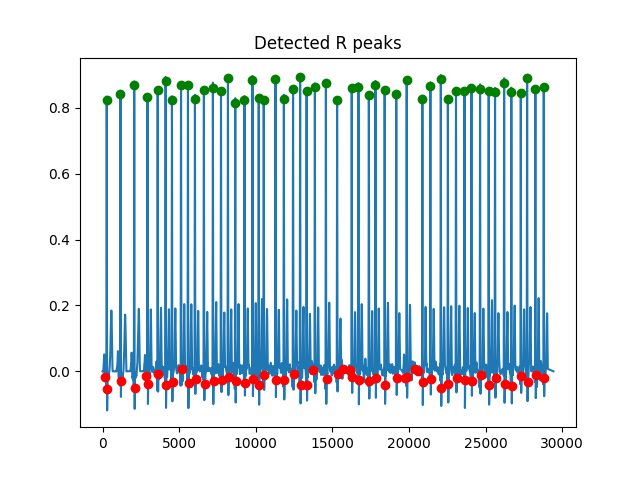

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from ecgdetectors import Detectors
import sys


unfiltered_ecg_dat = np.transpose(np.array(returndata['multileadECG']))
unfiltered_ecg = unfiltered_ecg_dat[:, 0]
fs = 500

detectors = Detectors(fs)

predictedpeaks = []
for i in range(len(detectors.get_detector_list())):
    if i==1:
        predictedpeaks.append([])
        continue
    predictedpeaks.append(detectors.get_detector_list()[i][1](unfiltered_ecg))

# If you want to always use the same det then directly call it:
#r_peaks = detectors.two_average_detector(unfiltered_ecg)
#r_peaks = detectors.matched_filter_detector(unfiltered_ecg,"templates/template_250hz.csv")
#r_peaks = detectors.swt_detector(unfiltered_ecg)
#r_peaks = detectors.engzee_detector(unfiltered_ecg)
#r_peaks = detectors.christov_detector(unfiltered_ecg)
#r_peaks = detectors.hamilton_detector(unfiltered_ecg)
#r_peaks = detectors.pan_tompkins_detector(unfiltered_ecg)
#r_peaks = detectors.wqrs_detector(unfiltered_ecg)

#predictedpeaks = np.array(r_peaks)

%matplotlib widget
plt.figure()
plt.plot(unfiltered_ecg)
plt.plot(predictedpeaks[0], unfiltered_ecg[predictedpeaks[0]], 'ro')
plt.plot(actualpeaks, unfiltered_ecg[actualpeaks], 'go')
plt.title("Detected R peaks")

plt.show()

In [72]:
numalgorithms = len(predictedpeaks)

tp = np.zeros(numalgorithms, dtype=int)
fp = np.zeros(numalgorithms, dtype=int)
fn = np.zeros(numalgorithms, dtype=int)

for j in range(len(predictedpeaks)):

    actualpeaksiter = actualpeaks

    for predictedpeak in predictedpeaks[j]:
        tpdetect = 1
        for i in range(len(actualpeaksiter)):
            if predictedpeak >= (actualpeaksiter[i] - 25) and predictedpeak <= (actualpeaksiter[i] + 25):
                tp[j]+=1
                tpdetect = 0
                actualpeaksiter = np.delete(actualpeaksiter, i)
                break
        if tpdetect:
            fp[j]+=1

    for actualpeak in actualpeaksiter:
        fn[j]+=1

print("actual peaks = ", len(actualpeaks))
print("predicted peaks = ", [len(predictedpeaksperalg) for predictedpeaksperalg in predictedpeaks])
print("true positive = ", tp)
print("false positive = ", fp)
print("false negative = ", fn)

actual peaks =  50
predicted peaks =  [57, 0, 51, 50, 51, 51, 51, 52]
true positive =  [ 0  0 14 49 50 49  1 49]
false positive =  [57  0 37  1  1  2 50  3]
false negative =  [50 50 36  1  0  1 49  1]


In [73]:
sensitivity = tp / (tp+fn)
print("sensitivity = ", np.around(sensitivity,decimals=2))

positive_predictivity = tp / (tp+fp)
print("positive predictivity = ", np.around(positive_predictivity,decimals=2))

f1_score = tp / (tp+.5*(fp+fn))
print("f1 score = ", np.around(f1_score,decimals=2))

sensitivity =  [0.   0.   0.28 0.98 1.   0.98 0.02 0.98]
positive predictivity =  [0.    nan 0.27 0.98 0.98 0.96 0.02 0.94]
f1 score =  [0.   0.   0.28 0.98 0.99 0.97 0.02 0.96]


C:\Users\flori\AppData\Local\Temp\ipykernel_29376\1440835149.py:4: RuntimeWarning: invalid value encountered in divide
  positive_predictivity = tp / (tp+fp)
